In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray'

import scipy.sparse as sp
from sklearn.neighbors import kneighbors_graph
from tensorflow.keras.datasets import mnist as m
from sklearn.model_selection import train_test_split

MNIST_SIZE = 28

In [5]:
def load_data(k=8, noise_level=0.0, random_state=None):
    """
    Loads the MNIST dataset and a K-NN graph to perform graph signal
    classification, as described by [Defferrard et al. (2016)](https://arxiv.org/abs/1606.09375).
    The K-NN graph is statically determined from a regular grid of pixels using
    the 2d coordinates.

    The node features of each graph are the MNIST digits vectorized and rescaled
    to [0, 1].
    Two nodes are connected if they are neighbours according to the K-NN graph.
    Labels are the MNIST class associated to each sample.
    :param k:
    :param noise_level:
    :param random_state:
    :return:
        - X_train, y_train: training node features and labels;
        - X_val, y_val: validation node features and labels;
        - X_test, y_test: test node features and labels;
        - A: adjacency matrix of the grid;
    """
    A = _mnist_grid_graph(k)
    if random_state is not None:
        np.random.seed(random_state)
    A = _flip_random_edges(A, noise_level).astype(np.float32)

    (X_train, y_train), (X_test, y_test) = m.load_data()
    X_train, X_test = X_train / 255., X_test / 255.
    X_train = X_train.reshape(-1, MNIST_SIZE ** 2)
    X_test = X_test.reshape(-1, MNIST_SIZE ** 2)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test, A

def _grid_coordinates(side):
    """
    Returns 2D coordinates for a square grid of equally spaced nodes.
    :param side: int, the side of the grid (i.e., the grid has side * side nodes)
    :return: np.array of shape (side * side, 2)
    """
    M = side ** 2
    x = np.linspace(0, 1, side, dtype=np.float32)
    y = np.linspace(0, 1, side, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    return z

def _get_adj_from_data(X, k, **kwargs):
    """
    Computes adjacency matrix of a K-NN graph from the given data.
    :param X: rank 1 np.array, the 2D coordinates of pixels on the grid.
    :param kwargs: kwargs for sklearn.neighbors.kneighbors_graph (see docs
    [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html)).
    :return: scipy sparse matrix.
    """
    A = kneighbors_graph(X, k, **kwargs).toarray()
    A = sp.csr_matrix(np.maximum(A, A.T))
    return A

def _mnist_grid_graph(k):
    """
    Get the adjacency matrix for the KNN graph.
    :param k: int, number of neighbours for each node;
    :return:
    """
    X = _grid_coordinates(MNIST_SIZE)
    A = _get_adj_from_data(X, k, mode='connectivity', metric='euclidean', include_self=False)
    return A

def _flip_random_edges(A, percent):
    """
    Flips values of A randomly.
    :param A: binary scipy sparse matrix.
    :param percent: percent of the edges to flip.
    :return: binary scipy sparse matrix.
    """
    if not A.shape[0] == A.shape[1]:
        raise ValueError('A must be a square matrix.')
    dtype = A.dtype
    A = sp.lil_matrix(A).astype(np.bool)
    n_elem = A.shape[0] ** 2
    n_elem_to_flip = round(percent * n_elem)
    unique_idx = np.random.choice(n_elem, replace=False, size=n_elem_to_flip)
    row_idx = unique_idx // A.shape[0]
    col_idx = unique_idx % A.shape[0]
    idxs = np.stack((row_idx, col_idx)).T
    for i in idxs:
        i = tuple(i)
        A[i] = np.logical_not(A[i])
    A = A.tocsr().astype(dtype)
    A.eliminate_zeros()
    return A

In [6]:
print(_grid_coordinates(28).shape)

(784, 2)


In [7]:
print(_get_adj_from_data(_grid_coordinates(28), 8, mode='connectivity', metric='euclidean', include_self=False))

  (0, 1)	1.0
  (0, 2)	1.0
  (0, 28)	1.0
  (0, 29)	1.0
  (0, 30)	1.0
  (0, 56)	1.0
  (0, 57)	1.0
  (0, 58)	1.0
  (1, 0)	1.0
  (1, 2)	1.0
  (1, 3)	1.0
  (1, 28)	1.0
  (1, 29)	1.0
  (1, 30)	1.0
  (1, 56)	1.0
  (1, 57)	1.0
  (2, 0)	1.0
  (2, 1)	1.0
  (2, 3)	1.0
  (2, 4)	1.0
  (2, 29)	1.0
  (2, 30)	1.0
  (2, 31)	1.0
  (2, 58)	1.0
  (3, 1)	1.0
  :	:
  (780, 782)	1.0
  (781, 725)	1.0
  (781, 752)	1.0
  (781, 753)	1.0
  (781, 754)	1.0
  (781, 779)	1.0
  (781, 780)	1.0
  (781, 782)	1.0
  (781, 783)	1.0
  (782, 726)	1.0
  (782, 752)	1.0
  (782, 753)	1.0
  (782, 754)	1.0
  (782, 755)	1.0
  (782, 780)	1.0
  (782, 781)	1.0
  (782, 783)	1.0
  (783, 725)	1.0
  (783, 726)	1.0
  (783, 727)	1.0
  (783, 753)	1.0
  (783, 754)	1.0
  (783, 755)	1.0
  (783, 781)	1.0
  (783, 782)	1.0


In [8]:
def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout, draw_labels=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]
    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'blue'))
        edge_width.append(g.edges[e].get('width', 1))
    nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='s', node_size=400, alpha=0.75, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, shift_pos, labels=node_labels, ax=ax)
    ax.autoscale()
    return fig, ax, pos

In [9]:
xx, yy = np.meshgrid(np.arange(MNIST_SIZE), np.arange(MNIST_SIZE))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test, adj = load_data(k=8)

D:\Anaconda\envs\graph-nx\lib\site-packages\ipykernel_launcher.py:81: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


7


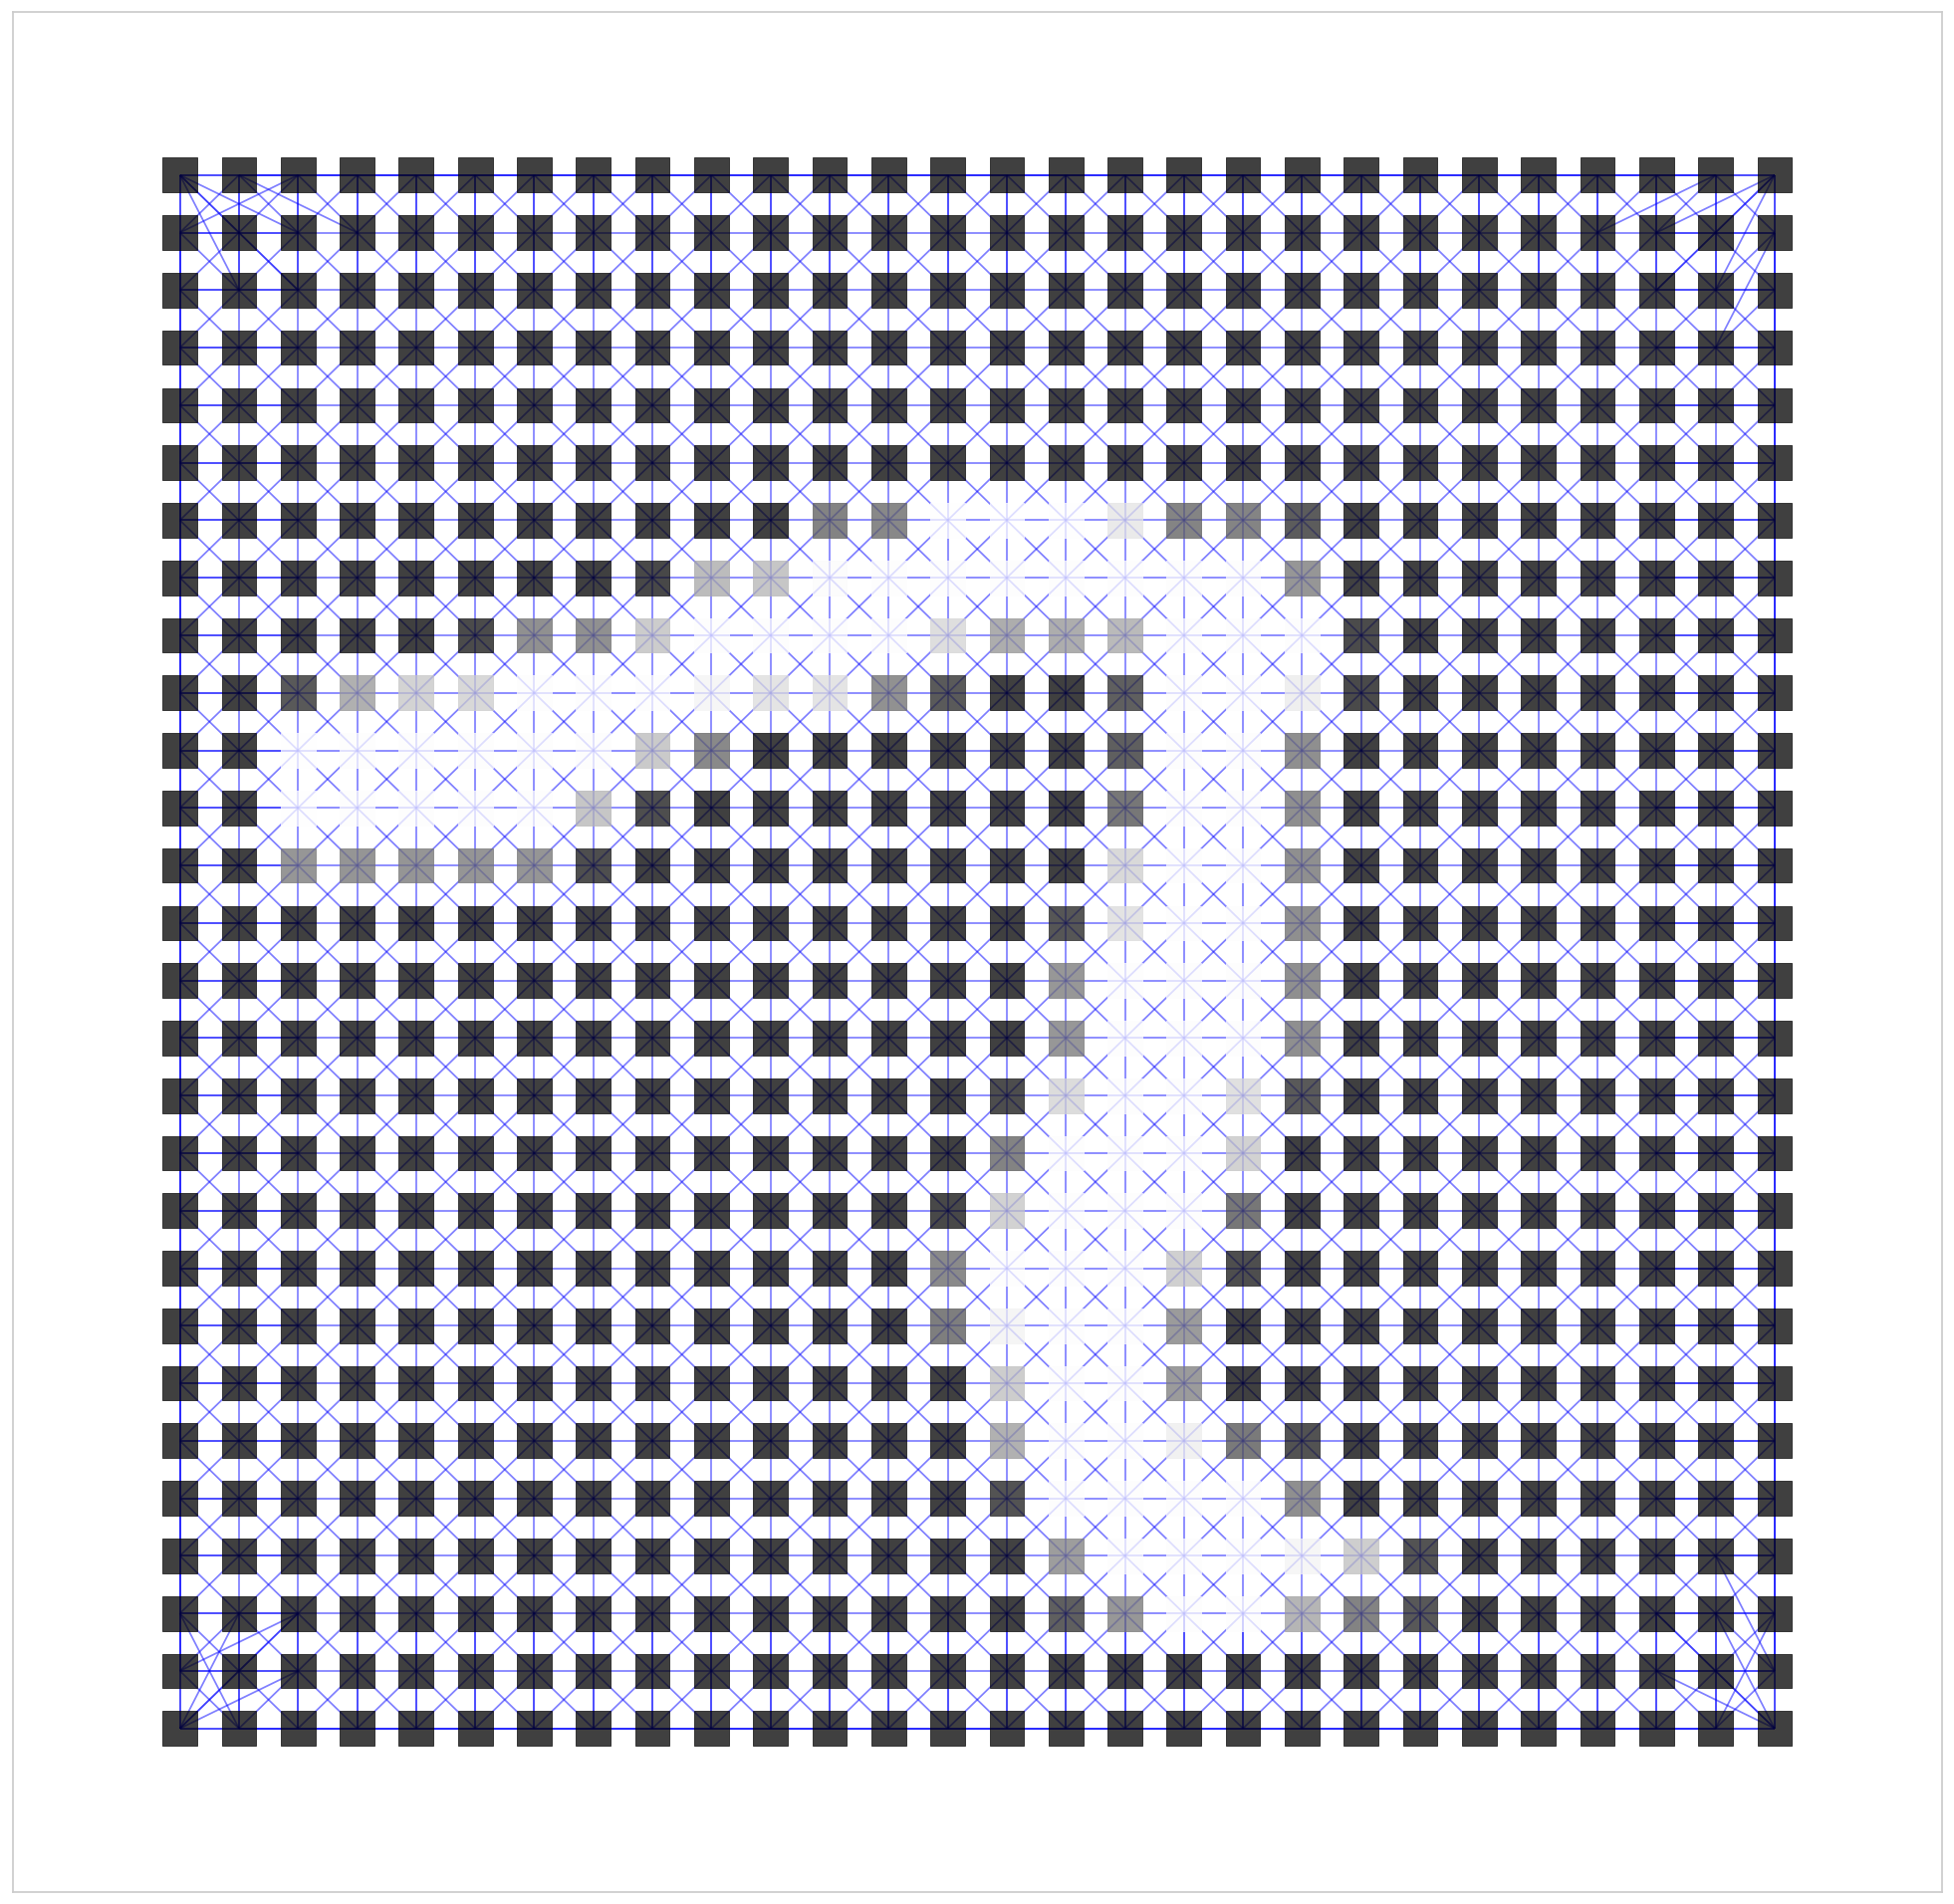

In [11]:
G = nx.from_scipy_sparse_matrix(adj)
idx = 4
for k, val in zip(G.nodes, X_train[idx].reshape((MNIST_SIZE, MNIST_SIZE))[::-1,:].flatten()):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = val
draw_graph_mpl(G, pos=np.stack([xx.ravel(), yy.ravel()], -1), draw_labels=False);
print(y_train[idx])
plt.savefig(str(y_train[idx])+'.png', bbox_inches='tight')

In [12]:
X_train[idx].shape

(784,)

In [13]:
(X_train, y_train), (X_test, y_test) = m.load_data()

In [14]:
X_train[0].shape

(28, 28)

In [16]:
class ImageGrid(object):
    def __init__(self, array=None, diff_edge=False, seed=32):
        """[summary]

        Args:
            array ([numpy array], optional): [H W C=1,3 tensor]. Defaults to None.
            diff_edge (bool, optional): [description]. Defaults to False.
        """
        self.reset()
        # self.set_array(array, diff_edge=diff_edge)
        self.array = array.astype(np.float32) if array.ndim == 3 else np.expand_dims(array, axis=2)
        self.height, self.width = array.shape[:2]
        self.seed = seed
        # Create the graph
        self.graph = nx.grid_2d_graph(self.height, self.width)

        self.set_nodes(weight=None)
        self.set_edges(weight=None, diff_edge=diff_edge)
        # for n, node in enumerate(self.graph.nodes):
        #     print(self.graph.nodes[node])
        self.number_of_nodes = self.graph.number_of_nodes()
        self.number_of_edges = self.graph.number_of_edges()

    def reset(self):
        self.height = 0
        self.width = 0
        self.array = None
        self.graph = None

    def set_edges(self, weight=None, diff_edge=True, cc=8):
        # for e, edge in enumerate(self.graph.edges):
        #     self.graph.edges[edge]['weight'] = 0.5

        if cc==8:
            k=1
            self.graph.add_edges_from([
                                          ((x+0, y+0), (x+0, y+k))
                                          for x in range(self.width-k)
                                          for y in range(self.height-k)
                                      ] + [
                                          ((x+0, y+0), (x+k, y+0))
                                          for x in range(self.width-k)
                                          for y in range(self.height-k)
                                      ] + [
                                          ((x+k, y+0), (x+k, y+k))
                                          for x in range(self.width-k)
                                          for y in range(self.height-k)
                                      ] + [
                                          ((x+0, y+k), (x+k, y+k))
                                          for x in range(self.width-k)
                                          for y in range(self.height-k)
                                      ], weight=0.5)

            # diagonal edges
            self.graph.add_edges_from([
                                          ((x+0, y+0), (x+k, y+k))
                                          for x in range(self.width-k)
                                          for y in range(self.height-k)
                                      ] + [
                                          ((x+k, y+0), (x+0, y+k))
                                          for x in range(self.width-k)
                                          for y in range(self.height-k)
                                      ], weight=0.5)

            np.random.seed(self.seed)
            # k = np.random.choice([2, 4, 8, 16])
            # straight edges
            x = np.random.choice(self.width, size=(self.height*self.width//4), replace=True)
            y = np.random.choice(self.height,  size=(self.height*self.width//4), replace=True)
            u = np.random.choice(self.width, size=(self.height*self.width//4), replace=True)
            v = np.random.choice(self.height,  size=(self.height*self.width//4), replace=True)
            self.graph.add_edges_from([
                ((x, y), (u, v)) for x, y, u, v in zip(x, y, u, v)
            ], weight=0.5)

            # # diagonal edges
            # self.graph.add_edges_from([
            #     ((x+0, y+0), (x+k, y+k))
            #     for x in range(self.width-k)
            #     for y in range(self.height-k)
            # ] + [
            #     ((x+k, y+0), (x+0, y+k))
            #     for x in range(self.width-k)
            #     for y in range(self.height-k)
            # ], weight=0.5)

        elif cc==4:
            # connected component is equal to 4 already in the grid
            pass

        # Add edge to master node
        self.graph.add_edges_from([
            ((x, y), (-1, 0))
            for x in range(self.width)
            for y in range(self.height)
        ], weight=0.5)

        self.graph.add_edges_from([
            ((x, y), (0, -1))
            for x in range(self.width)
            for y in range(self.height)
        ], weight=0.5)


        if diff_edge=="mean":
            for e, edge in enumerate(self.graph.edges):
                # Compute the mean of the affinity
                self.graph.edges[edge]['weight'] = (self.array[edge[0]] - self.array[edge[1]]) * 0.5
        elif diff_edge=="diff":
            for e, edge in enumerate(self.graph.edges):
                # Compute the affinity, 1 - difference
                self.graph.edges[edge]['weight'] = ( 1 - np.abs(self.array[edge[0]] - self.array[edge[1]]) )
                # if self.array[edge[0]] == self.array[edge[1]] == 0: # We dont care the connection of background
                #     self.graph.edges[edge]['weight'] = np.abs(self.array[edge[0]] - self.array[edge[1]]) # 0
                # else:
                #     self.graph.edges[edge]['weight'] = ( 1 - np.abs(self.array[edge[0]] - self.array[edge[1]]) )

    def set_nodes(self, weight=None):
        for n, node in enumerate(self.graph.nodes):
            y = n // self.width
            x = n % self.width
            self.graph.nodes[node]['weight'] = self.array[y,x,:]\
                if weight is None else np.array([weight], dtype=np.float32)
        # Set master node
        self.graph.add_node((-1, 0), weight=np.array([1.0], dtype=np.float32) if weight is None else np.array([weight], dtype=np.float32))
        self.graph.add_node((0, -1), weight=np.array([0.0], dtype=np.float32) if weight is None else np.array([weight], dtype=np.float32))

In [17]:
X_train[0].shape

(28, 28)

In [18]:
image_grid = ImageGrid(X_train[0], diff_edge="diff", seed=42)

In [19]:
image_grid

In [21]:
import torch_geometric

In [22]:
image_graph = torch_geometric.utils.from_networkx(image_grid.graph,
                                                  group_node_attrs=['weight'],
                                                  group_edge_attrs=['weight'])

In [23]:
image_graph

Data(edge_index=[2, 9466], x=[786, 1], edge_attr=[9466, 1])

In [26]:
image_graph.y = [y_train[0]]

In [27]:
image_graph

Data(edge_index=[2, 9466], x=[786, 1], edge_attr=[9466, 1], y=[1])